# 📘 Modeling: Student Performance and Risk Prediction

This notebook covers the modeling phase of the student data performance project. It includes predictive modeling for student grades and classification of at-risk students, along with model evaluation and selection.

In this notebook, we:
- Develop a regression model to predict student GPA
- Derive a binary risk label (`risk_flag`) based on GPA
- Train a classificication model to identify at-risk students
- Evaluate and compare model performance
- Tuning top models
- Save models for deployment

In [1]:
# 1. Load packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error,classification_report,
                             accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

c:\Users\FRANK\anaconda3\envs\learn-env\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load Data and Split Features

**1. Load Data**

In [2]:
# 1. Load Processed Data
file_path = "../data/feature_engineered_student_data.csv"
df = pd.read_csv(file_path)

**2. Split Data into Targets and Features**

In [3]:
# 2. Prepare Targets and Features
X = df.drop(columns=['risk_flag', 'gpa', 'gradeclass'])

# Separate targets for regression and classification
y_reg = df['gpa']
y_cls = df['risk_flag']

# Sanity check
print("✅ Features and targets prepared:")
print(f"X shape: {X.shape}, y_reg shape: {y_reg.shape}, y_cls shape: {y_cls.shape}")

✅ Features and targets prepared:
X shape: (2392, 14), y_reg shape: (2392,), y_cls shape: (2392,)


**3. Train-Test Split for Regression and Classification**

In [4]:
# Split data for GPA regression 
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
# Split data for At-Risk classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.2, random_state=42)

**4. GPA Regression Models**

In [5]:
# Initialize Models
reg_models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42)
}
print("📈 GPA Regression Results: \n")
for name, model in reg_models.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)
    print(f"{name} - R²: {r2_score(y_test_reg, y_pred):.4f}, "
          f"MAE: {mean_absolute_error(y_test_reg, y_pred):.4f}, "
          f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred)):.4f}")

📈 GPA Regression Results: 

LinearRegression - R²: 0.9533, MAE: 0.1553, RMSE: 0.1966
RandomForestRegressor - R²: 0.9275, MAE: 0.1896, RMSE: 0.2448
XGBRegressor - R²: 0.9315, MAE: 0.1874, RMSE: 0.2380


**5. Save Best GPA Model**

In [6]:
# Choose best regression model (manually or based on scores)
best_reg_model = reg_models['LinearRegression'] # Example: Linear Regression is chosen based on R² score
joblib.dump(best_reg_model, "../models/lr_student_grade_model.pkl")
print("Best GPA model saved!")

Best GPA model saved!


**5.1 Classify At-Risk Students Using Threshold `< 0.2` on Model Predicted Results**


📌 Classification Report from predicted GPA:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1118
           1       0.95      0.94      0.95      1274

    accuracy                           0.95      2392
   macro avg       0.95      0.95      0.95      2392
weighted avg       0.95      0.95      0.95      2392



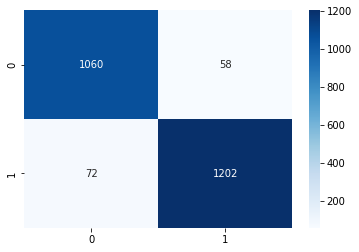

In [7]:
# Predict GPA for entire dataset (optional for comparison)
y_pred_gpa = best_reg_model.predict(X)
y_pred_cls = (y_pred_gpa < 2.0).astype(int)

print("\n📌 Classification Report from predicted GPA:")
print(classification_report(y_cls, y_pred_cls))
sns.heatmap(confusion_matrix(y_cls, y_pred_cls), annot=True, fmt='d', cmap='Blues');

**6. Risk Classification Models (_Classification Modeling Based on Features_)**

In [8]:
# Classification Modeling Based on Features Directly
cls_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

print("\n At-Risk Student Classification Results:")
for name, model in cls_models.items():
    model.fit(X_train_cls, y_train_cls)
    y_pred_cls_model = model.predict(X_test_cls)
    print(f"\n{name}")
    print(classification_report(y_test_cls, y_pred_cls_model))
    print(f"F1 Score: {f1_score(y_test_cls, y_pred_cls_model):.4f}")


 At-Risk Student Classification Results:

LogisticRegression
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       230
           1       0.93      0.95      0.94       249

    accuracy                           0.94       479
   macro avg       0.94      0.94      0.94       479
weighted avg       0.94      0.94      0.94       479

F1 Score: 0.9423

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       230
           1       0.91      0.94      0.93       249

    accuracy                           0.92       479
   macro avg       0.92      0.92      0.92       479
weighted avg       0.92      0.92      0.92       479

F1 Score: 0.9267
[17:21:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in lan

**5.1 Tuning Models (RandomForestClassifier, XGBClassifier)**

- Random Forest

In [9]:
# Tuning Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_clf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf_clf, rf_params, scoring='f1', cv=5, n_iter=10, n_jobs=-1, random_state=42)
rf_search.fit(X_train_cls, y_train_cls)
best_rf = rf_search.best_estimator_

print("Best RF F1:", f1_score(y_test_cls, best_rf.predict(X_test_cls)))

Best RF F1: 0.9346534653465346


- XGBoost

In [10]:
# Tuning XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_search = RandomizedSearchCV(xgb_clf, xgb_params, scoring='f1', cv=5, n_iter=10, n_jobs=-1, random_state=42)
xgb_search.fit(X_train_cls, y_train_cls)
best_xgb = xgb_search.best_estimator_

print("Best XGB F1:", f1_score(y_test_cls, best_xgb.predict(X_test_cls)))

[17:21:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best XGB F1: 0.9404761904761904


After tuning RFClassifier and XGBClassifier, Logistic Regression remains to be the best performing model. 

**5.2 Save Best Model**

In [11]:
best_cls_model = cls_models['LogisticRegression'] # or the best one
joblib.dump(best_cls_model, "../models/logreg_risk_classifier_model.pkl")
print("Best Classifier Model Saved!")

Best Classifier Model Saved!


### Notes:

In [12]:
import sklearn
print(sklearn.__version__)  # Should output 1.6.1

1.3.2
